# 농산물 가격 예측 모형
## 비즈니스 애널리틱스 8팀 박지헌
  
    
## 0. 라이브러리 & 데이터프레임 전처리

In [2]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
%matplotlib inline
from fbprophet import Prophet
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import pyplot
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn import metrics  # 나머지는 sklearn에서 활용
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error,mean_squared_log_error
import eli5
from eli5.sklearn import PermutationImportance
# pd.set_option('mode.chained_assignment',  None)
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

In [6]:
df = pd.read_csv('data/rice_weather3.csv')
df['date']=pd.to_datetime(df['date'])

### 0.1 결측값 확인

<AxesSubplot:>

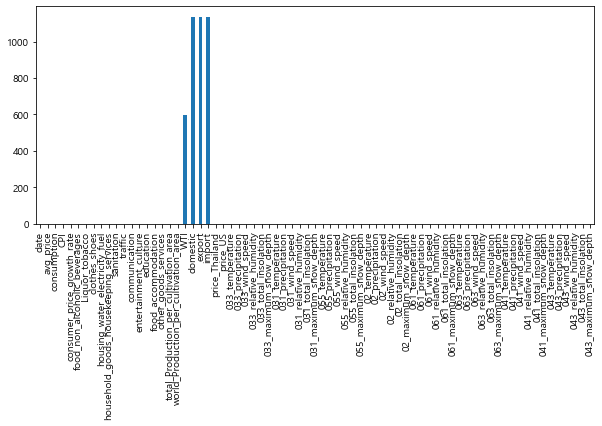

In [7]:
# pd.set_option("max_rows", None)
fig = plt.figure(figsize=(10, 4))
df.isnull().sum().plot(kind='bar')

<AxesSubplot:>

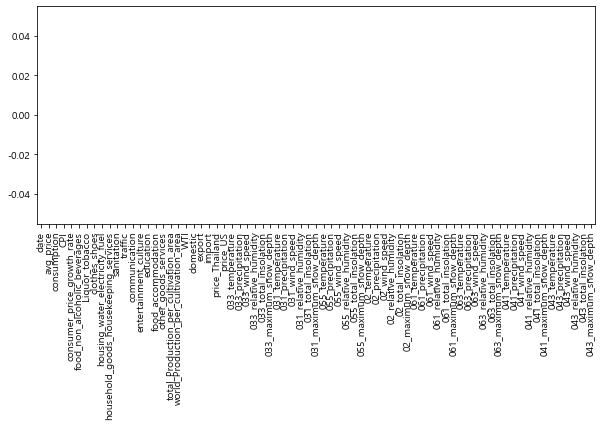

In [8]:
df['WTI'].interpolate(method='linear',limit_direction='forward',inplace=True)
df.dropna(inplace=True)

# pd.set_option("max_rows", None)
fig = plt.figure(figsize=(10, 4))
df.isnull().sum().plot(kind='bar')

### 0.2 이상값 확인

<AxesSubplot:xlabel='date', ylabel='WTI'>

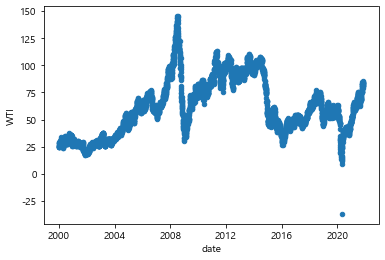

In [9]:
df.plot(kind='scatter',x='date', y='WTI')

<AxesSubplot:xlabel='date', ylabel='WTI'>

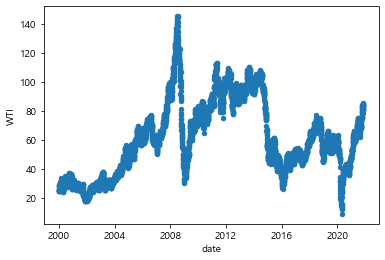

In [10]:
cond = (df["WTI"] < 0)
df[cond]

df.drop(6392,inplace=True)
df.plot(kind='scatter',x='date', y='WTI')

In [131]:
# df.to_csv("data/rice_df.csv",index=False)

In [11]:
df=pd.read_csv("data/rice_df2.csv")
df['date']=pd.to_datetime(df['date'])
df

,date,avg_price,consumption,CPI,consumer_price_growth_rate,food_non_alcoholic_beverages,Liquor_tobacco,clothes_shoes,housing_water_electricity_fuel,household_goods_housekeeping_services,...,export,import,price_Thailand,price_US,temperature,precipitation,wind_speed,relative_humidity,total_insolation,maximum_snow_depth
0,2000-01-03,41900,93.600,66.6,2.3,0.8,0.8,1.5,3.7,-2.5,...,0,43034642,247.500000,0.499000,0.692857,0.000000,2.100000,56.707143,4.188571,0.000000
1,2000-01-04,41900,93.600,66.6,2.3,0.8,0.8,1.5,3.7,-2.5,...,0,43034642,247.500000,0.499000,1.428571,0.000000,1.271429,56.035714,3.552143,0.000000
2,2000-01-05,41800,93.600,66.6,2.3,0.8,0.8,1.5,3.7,-2.5,...,0,43034642,247.500000,0.499000,5.642857,10.550000,2.450000,75.957143,1.521429,1.185714
3,2000-01-06,41800,93.600,66.6,2.3,0.8,0.8,1.5,3.7,-2.5,...,0,43034642,247.500000,0.499000,5.171429,5.421429,3.078571,75.964286,1.362857,0.428571
4,2000-01-07,41900,93.600,66.6,2.3,0.8,0.8,1.5,3.7,-2.5,...,0,43034642,247.500000,0.499000,-3.750000,0.442857,2.935714,56.807143,3.915000,1.028571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5636,2021-11-05,54020,52.609,105.4,0.5,4.4,0.3,0.7,0.5,0.0,...,196359,36667741,496.120606,0.745517,12.220000,4.393333,1.293333,72.720000,6.414667,0.000000
5637,2021-11-08,53880,52.609,105.4,0.5,4.4,0.3,0.7,0.5,0.0,...,196359,36667741,496.120606,0.745517,9.786667,19.986667,2.686667,78.246667,2.232667,0.000000
5638,2021-11-09,53880,52.609,105.4,0.5,4.4,0.3,0.7,0.5,0.0,...,196359,36667741,496.120606,0.745517,7.020000,1.226667,2.260000,72.180000,4.563333,0.000000
5639,2021-11-10,53880,52.609,105.4,0.5,4.4,0.3,0.7,0.5,0.0,...,196359,36667741,496.120606,0.745517,6.453333,3.106667,2.253333,74.633333,4.077333,0.000000


## 1. EDA

### 1.2 파트별 상관관계분석
#### 1.2.1 품목별 소비자 물가 지수

C:\Users\82104\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\82104\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:title={'center':'쌀 가격 - 소비자 물가지수 상관계수'}>

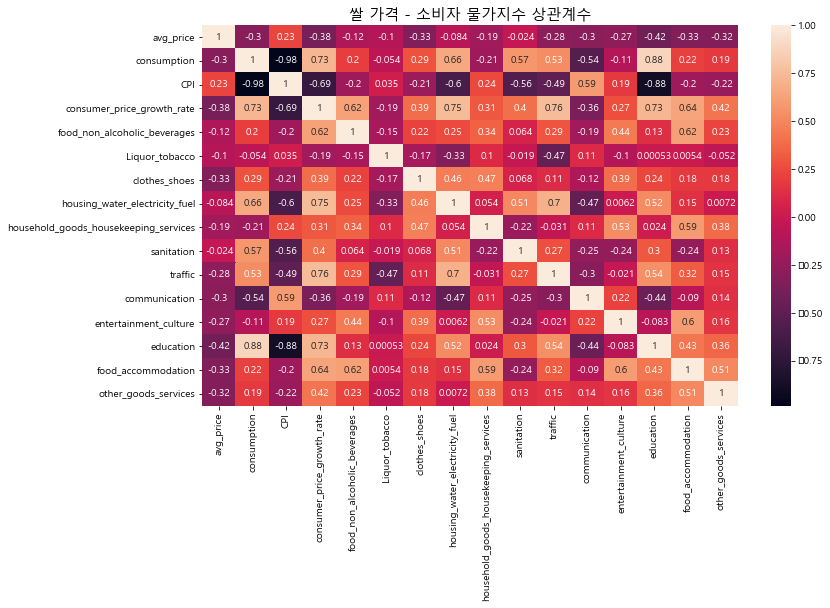

In [5]:
# 품목별 소비자 물가지수
consumer_vars = df[['date','avg_price', 'consumption', 'CPI', 'consumer_price_growth_rate',
       'food_non_alcoholic_beverages', 'Liquor_tobacco', 'clothes_shoes',
       'housing_water_electricity_fuel',
       'household_goods_housekeeping_services', 'sanitation', 'traffic',
       'communication', 'entertainment_culture', 'education',
       'food_accommodation', 'other_goods_services']]

consumer_vars

plt.rcParams['figure.figsize']=[12,7] #크기조정 [가로,높이]인치
plt.title("쌀 가격 - 소비자 물가지수 상관계수", fontsize=15)
sns.heatmap(consumer_vars.corr(),annot=True)

array([[<AxesSubplot:title={'center':'date'}>,
        <AxesSubplot:title={'center':'avg_price'}>,
        <AxesSubplot:title={'center':'consumption'}>,
        <AxesSubplot:title={'center':'CPI'}>],
       [<AxesSubplot:title={'center':'consumer_price_growth_rate'}>,
        <AxesSubplot:title={'center':'food_non_alcoholic_beverages'}>,
        <AxesSubplot:title={'center':'Liquor_tobacco'}>,
        <AxesSubplot:title={'center':'clothes_shoes'}>],
       [<AxesSubplot:title={'center':'housing_water_electricity_fuel'}>,
        <AxesSubplot:title={'center':'household_goods_housekeeping_services'}>,
        <AxesSubplot:title={'center':'sanitation'}>,
        <AxesSubplot:title={'center':'traffic'}>],
       [<AxesSubplot:title={'center':'communication'}>,
        <AxesSubplot:title={'center':'entertainment_culture'}>,
        <AxesSubplot:title={'center':'education'}>,
        <AxesSubplot:title={'center':'food_accommodation'}>],
       [<AxesSubplot:title={'center':'other_goods_servi

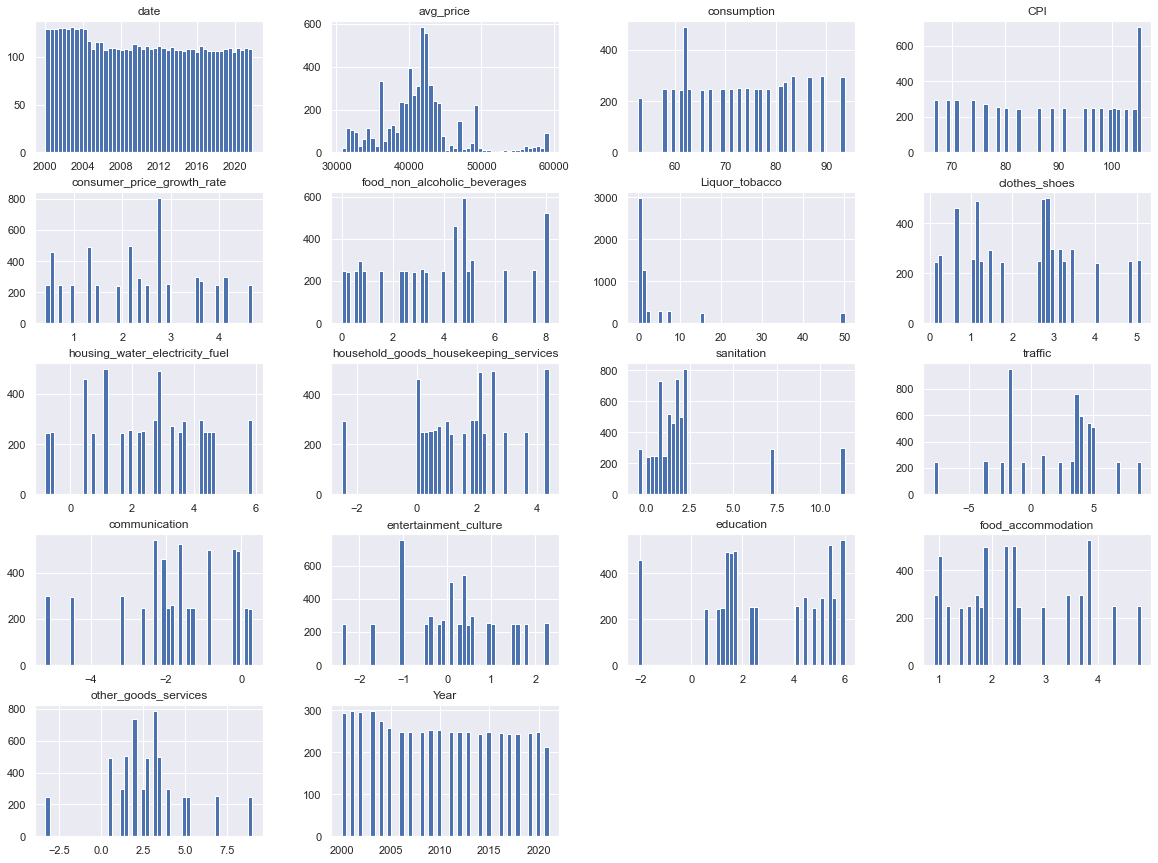

In [150]:
consumer_vars.hist(bins=50, figsize=(20, 15))

<Figure size 864x576 with 0 Axes>

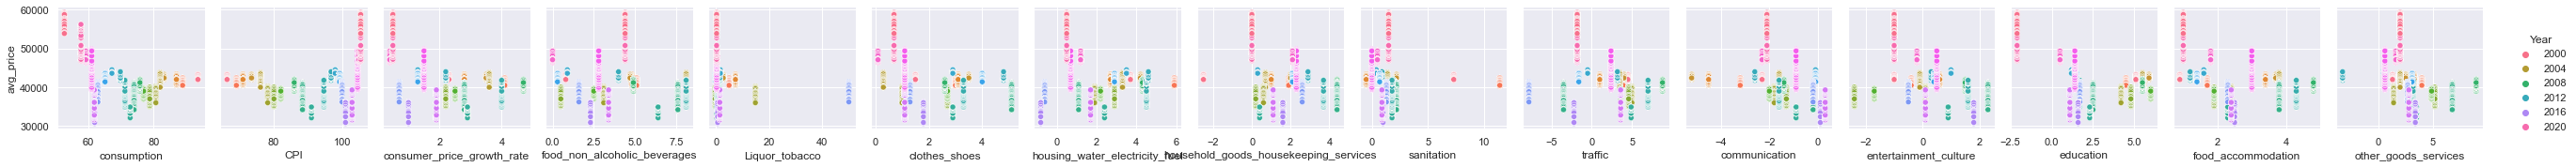

In [71]:
consumer_vars['Year'] = df['date'].dt.year;consumer_vars
plt.figure(figsize=(12,8))
sns.pairplot(consumer_vars,
             x_vars=['consumption', 'CPI','consumer_price_growth_rate',
       'food_non_alcoholic_beverages', 'Liquor_tobacco', 'clothes_shoes',
       'housing_water_electricity_fuel',
       'household_goods_housekeeping_services', 'sanitation', 'traffic',
       'communication', 'entertainment_culture', 'education',
       'food_accommodation', 'other_goods_services'],
             y_vars=['avg_price'],
             kind='scatter',
             hue='Year',
             palette='husl')
plt.show()

#### 1.2.2 재배면적 당 수확량

<AxesSubplot:title={'center':'쌀 가격 - 지역별 재배면적 당 수확량 상관계수'}>

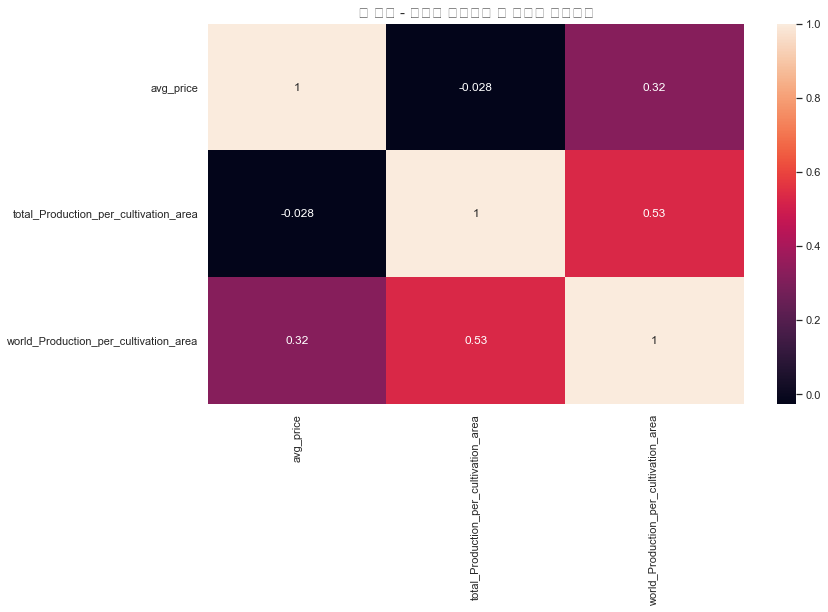

In [132]:
# 재배면적 당 수확량
local_vars = df[['avg_price','total_Production_per_cultivation_area',
       'world_Production_per_cultivation_area']]
plt.rcParams['figure.figsize']=[12,7] #크기조정 [가로,높이]인치
plt.title("쌀 가격 - 지역별 재배면적 당 수확량 상관계수", fontsize=15)
sns.heatmap(local_vars.corr(),annot=True)

array([[<AxesSubplot:title={'center':'avg_price'}>,
        <AxesSubplot:title={'center':'total_Production_per_cultivation_area'}>],
       [<AxesSubplot:title={'center':'world_Production_per_cultivation_area'}>,
        <AxesSubplot:>]], dtype=object)

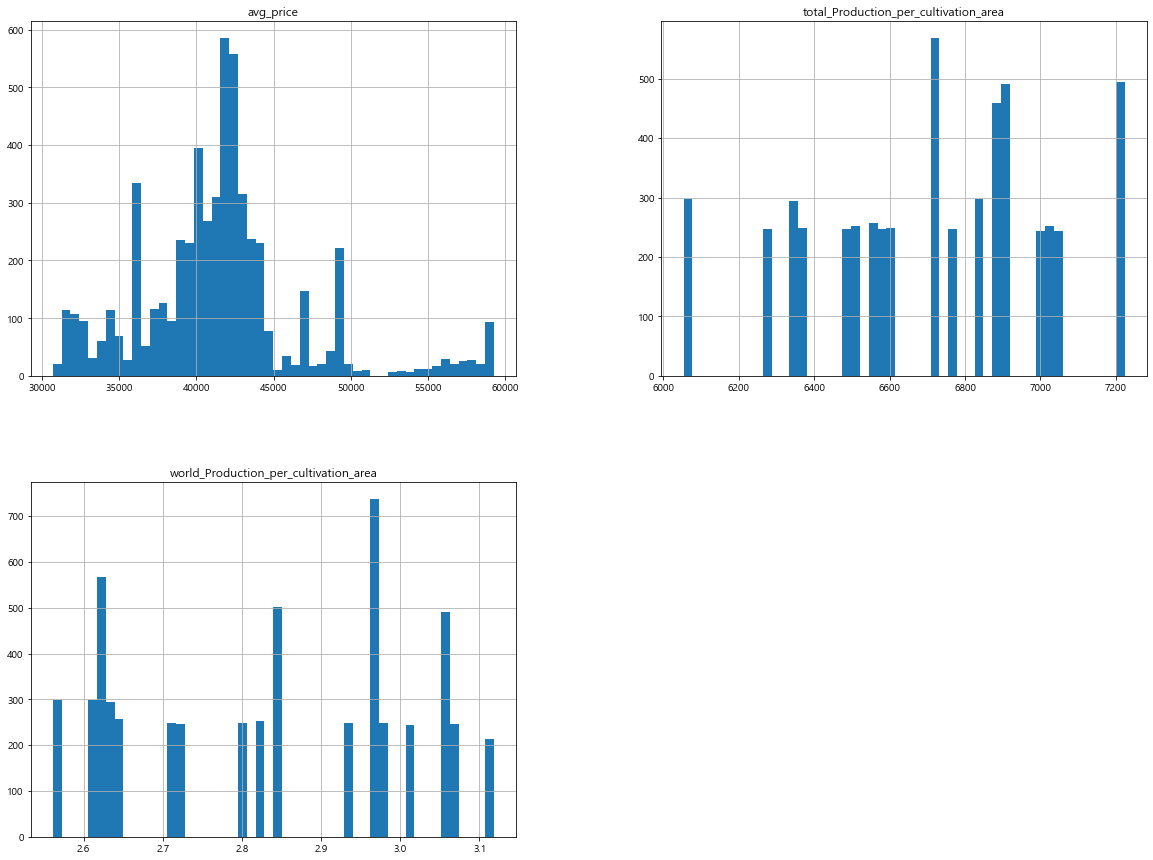

In [18]:
local_vars.hist(bins=50, figsize=(20, 15))

<ipython-input-135-a478685de506>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local_vars['Year'] = df['date'].dt.year;local_vars


<Figure size 864x576 with 0 Axes>

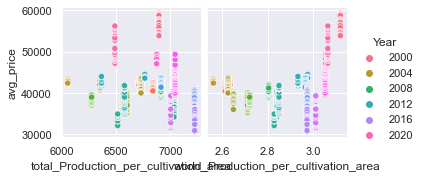

In [135]:
local_vars['Year'] = df['date'].dt.year;local_vars
plt.figure(figsize=(12,8))
sns.pairplot(local_vars,
             x_vars=['total_Production_per_cultivation_area',
       'world_Production_per_cultivation_area'],
             y_vars=['avg_price'],
             kind='scatter',
             hue='Year',
             palette='husl')
plt.show()

#### 1.2.3 국내 & 국제

<AxesSubplot:title={'center':'쌀 가격 - 국내 & 국제 상관계수'}>

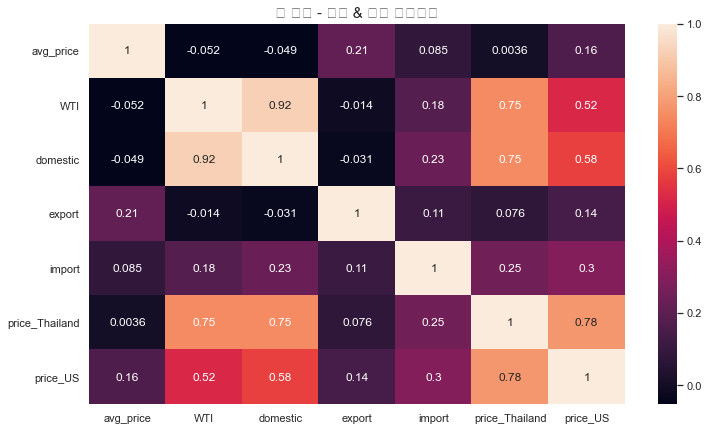

In [137]:
# 국내 & 국제
international_vars = df[['avg_price','WTI', 'domestic', 'export',
       'import', 'price_Thailand', 'price_US']]

plt.rcParams['figure.figsize']=[12,7] #크기조정 [가로,높이]인치
plt.title("쌀 가격 - 국내 & 국제 상관계수", fontsize=15)
sns.heatmap(international_vars.corr(),annot=True)

array([[<AxesSubplot:title={'center':'avg_price'}>,
        <AxesSubplot:title={'center':'WTI'}>,
        <AxesSubplot:title={'center':'domestic'}>],
       [<AxesSubplot:title={'center':'export'}>,
        <AxesSubplot:title={'center':'import'}>,
        <AxesSubplot:title={'center':'price_Thailand'}>],
       [<AxesSubplot:title={'center':'price_US'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

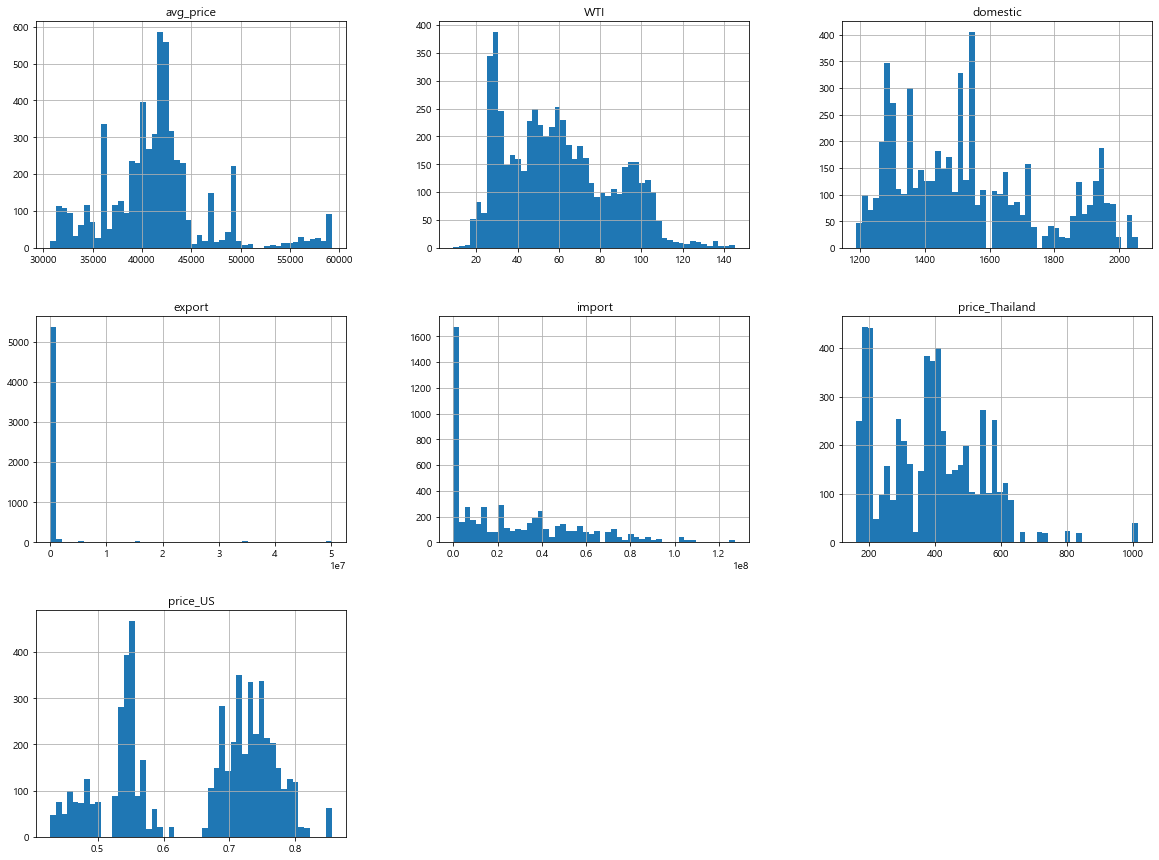

In [28]:
international_vars.hist(bins=50, figsize=(20, 15))

<ipython-input-138-271b388c4644>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  international_vars['Year'] = df['date'].dt.year


<Figure size 864x576 with 0 Axes>

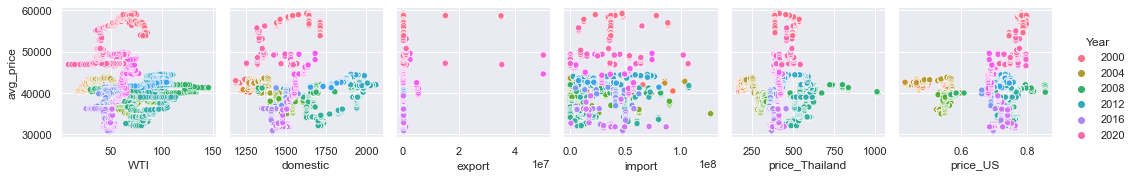

In [138]:
international_vars['Year'] = df['date'].dt.year
plt.figure(figsize=(12,8))
sns.pairplot(international_vars,
             x_vars=['WTI', 'domestic', 'export',
       'import', 'price_Thailand', 'price_US'],
             y_vars=['avg_price'],
             kind='scatter',
             hue='Year',
             palette='husl')
plt.show()

#### 1.2.4 지역별 기상

<AxesSubplot:title={'center':'쌀 가격 - 지역별 기상 상관계수'}>

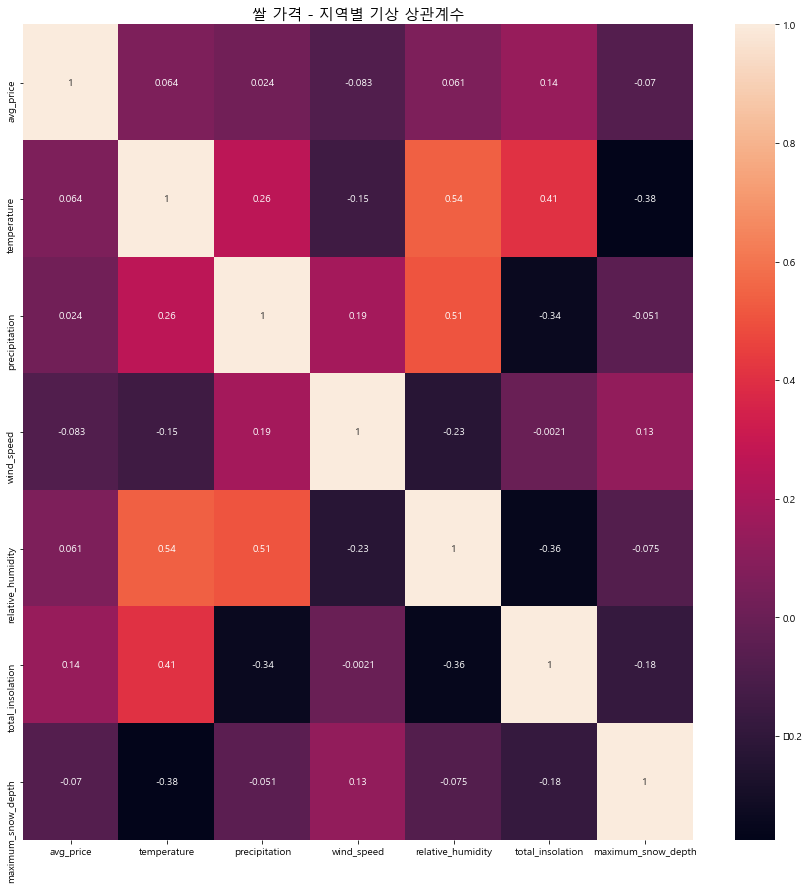

In [7]:
weather_vars = df[['avg_price','temperature',
       'precipitation', 'wind_speed', 'relative_humidity',
       'total_insolation', 'maximum_snow_depth']]


plt.rcParams['figure.figsize']=[15,15] #크기조정 [가로,높이]인치
plt.title("쌀 가격 - 지역별 기상 상관계수", fontsize=15)
sns.heatmap(weather_vars.corr(),annot=True)

C:\Users\82104\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\82104\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<Figure size 864x576 with 0 Axes>

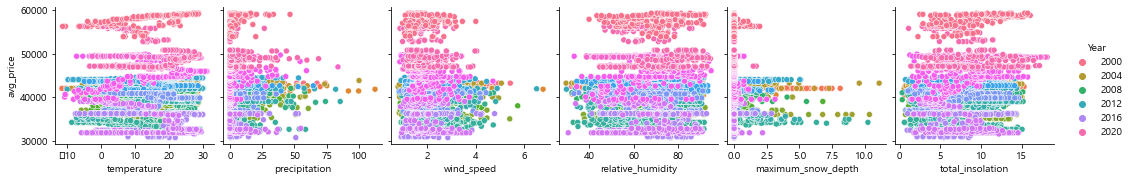

In [10]:
weather_vars['Year'] = df['date'].dt.year

plt.figure(figsize=(12,8))
sns.pairplot(weather_vars,
             x_vars=['temperature',
       'precipitation', 'wind_speed', 'relative_humidity',
        'maximum_snow_depth','total_insolation'],
             y_vars=['avg_price'],
             kind='scatter',
             hue='Year',
             palette='husl')
plt.show()

## 2. 가격 예측 모형
### 2.1 Prophet
* Facebook Prophet은 페이스북이 개발한 **일변량(하나의 변수)** 시계열 예측을 위한 오픈소스 라이브러리이다. 
* additive time series forecasting model을 참고해서 구현되었다.  
* **경향성(Trends), 계절성(seasonality), 휴일(holidays)** 을 지원하는 모델이다.

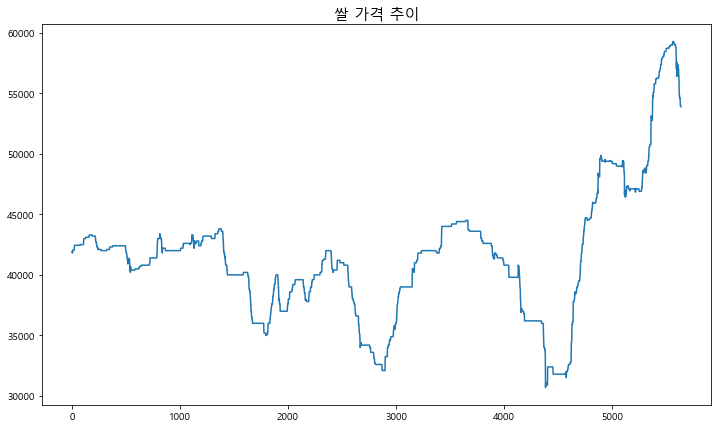

In [56]:
pro_df = df[['date', 'avg_price']]

plt.figure(figsize=(12,7))
plt.title("쌀 가격 추이", fontsize=15)
pro_df['avg_price'].plot()
pyplot.show()

#### 2.1.1 모델 학습: Prophet

In [47]:
# 컬럼명 변경
pro_df.columns = ['ds', 'y']

# 데이터 타입 변경
pro_df['ds']= pd.to_datetime(pro_df['ds'])

# 모델 생성
model = Prophet(yearly_seasonality=True, daily_seasonality=True)

# 모델 학습
model.fit(pro_df)

<ipython-input-47-aaaae1762298>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pro_df['ds']= pd.to_datetime(pro_df['ds'])


In [12]:
pro_df['ds']= pd.to_datetime(pro_df['ds'])
pro_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6779 entries, 0 to 6778
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      6779 non-null   datetime64[ns]
 1   y       6779 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 106.0 KB


<ipython-input-12-687ef13da825>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pro_df['ds']= pd.to_datetime(pro_df['ds'])


#### 2.1.2 검증: In-Sample Forecast

In [48]:
# train set 2016-01 ~ 2021-10
last_year = list()
for i in range(1, 13):
    last_year.append(['2016-%02d' % i])
for i in range(1, 13):
    last_year.append(['2017-%02d' % i])
for i in range(1, 13):
    last_year.append(['2018-%02d' % i])
for i in range(1, 13):
    last_year.append(['2019-%02d' % i])
for i in range(1, 13):
    last_year.append(['2020-%02d' % i])
for i in range(1, 11):
    last_year.append(['2021-%02d' % i])
last_year = pd.DataFrame(last_year, columns = ['ds'])
last_year['ds']= pd.to_datetime(last_year['ds'])

# 에측
forecast = model.predict(last_year)

In [14]:
#  예측값, 하한선, 상한선
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds          yhat    yhat_lower    yhat_upper
0 2016-01-01  35171.509857  33093.252195  37215.323197
1 2016-02-01  34608.385330  32664.519028  36555.377296
2 2016-03-01  33956.563327  31895.450321  36189.745461
3 2016-04-01  33240.021981  31225.663302  35526.980510
4 2016-05-01  32674.528164  30593.537637  34722.859733


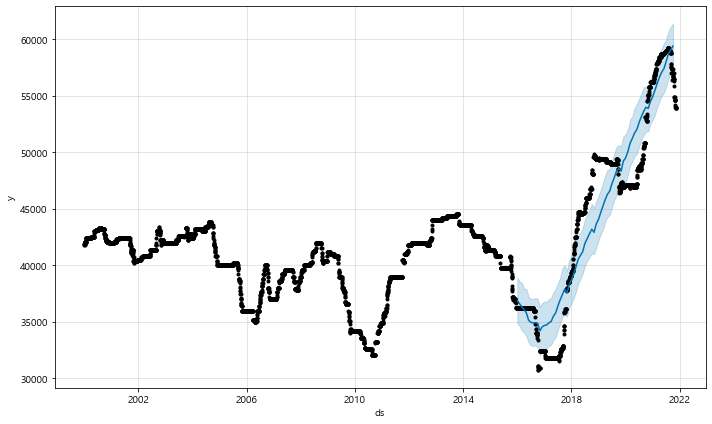

In [49]:
model.plot(forecast)
pyplot.show()

* 검은색 점들이 학습으로 사용된 데이터, 파란 색선이 예측한 값 
* 하늘색 범위는 상한선과 하한선
* 실제 데이터와 큰 차이가 없는 걸 보아 잘 학습된 것을 알 수 있다.  


#### 2.1.3 예측: Out-Of-Sample Forecast
* 학습 데이터 내부에 있었던 기간 외에 미래를 예측

In [50]:
# train set 이후 3년 날짜 생성 2021-11 ~ 2024-12
last_3year = list()
for i in range(11, 13):
    last_3year.append(['2021-%02d' % i])
for i in range(1, 13):
    last_3year.append(['2022-%02d' % i])
for i in range(1, 13):
    last_3year.append(['2023-%02d' % i])
for i in range(1, 13):
    last_3year.append(['2024-%02d' % i])
last_3year = pd.DataFrame(last_3year, columns = ['ds'])
last_3year['ds']= pd.to_datetime(last_3year['ds'])

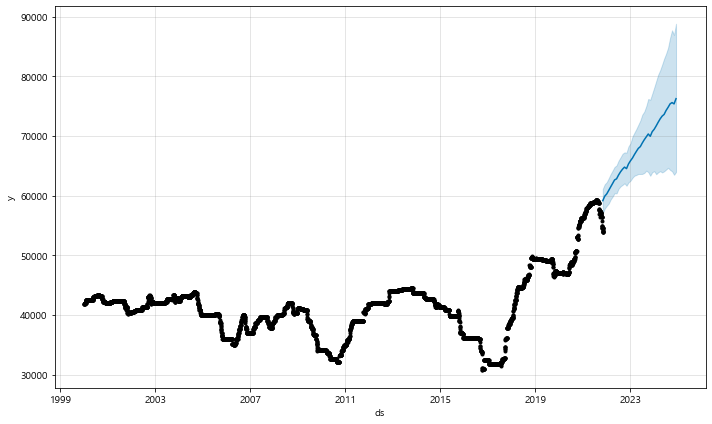

<Figure size 864x504 with 0 Axes>

In [51]:
forecast = model.predict(last_3year)
model.plot(forecast)
pyplot.show()
plt.savefig("data/output/pro_outsample.png", format = "png", dpi = 300)

#### 2.1.4 모델 평가
* 학습 데이터 내부에 있었던 기간 외에 미래를 예측

MAE: 15126.220


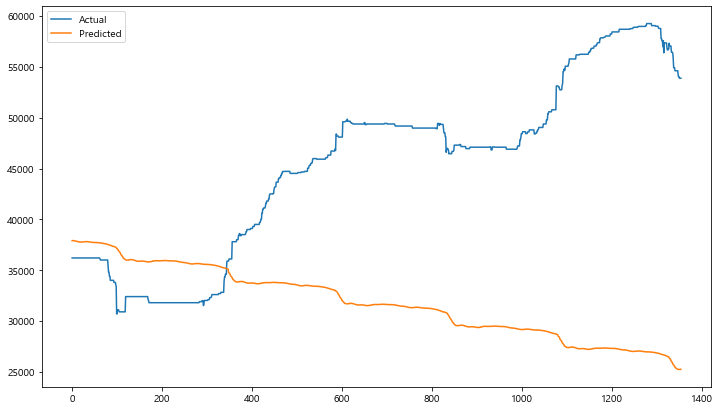

MAE: 15126.220


<Figure size 864x504 with 0 Axes>

In [52]:
# 마지막 20% 제외시키기
train = pro_df.drop(pro_df.index[-1355:])
y_true = pro_df['y'][-1355:].values

# 모델 생성 후 학습
model = Prophet(yearly_seasonality=True, daily_seasonality=True)
model.fit(train)

test = pro_df.drop(pro_df.index[:-1355])
last_year = list()
last_year = test['ds'].astype(str).values.tolist()
last_year = pd.DataFrame(last_year, columns = ['ds'])
last_year['ds']= pd.to_datetime(last_year['ds'])

# 예측하고 비교하기
forecast = model.predict(last_year)
y_pred = forecast['yhat'].values

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()
plt.savefig("data/output/pro_평가.png", format = "png", dpi = 300)
print('MAE: %.3f' % mae)

**MAE: 11816.284**
* mae가 작을수록 좋은 모델이다.
* 유의미한 예측 실패
* 경향성, 계절성, 휴일 등의 규칙적인 주기성으로 농산물 가격이 예측되지않아, 좀 더 **다양한 요인**이 필요해 보인다.

### 2.2 Multiple Regression
$$ y = a + b1*x1 + b2*x2 + b3*x3 ... bn*xn + e $$

* 현재 데이터의 열 83개
* 변수를 제거해야하는지 확인하는 작업이 사전에 필요하다.
* 그리고 다중공선성/과적합 등 문제가 발생하면 변수를 가공

#### 2.2.0 스케일링 전 & 후 비교

In [5]:
# 날짜 제거
df2 = df.iloc[:,1:]

In [6]:
# 스케일링 전
def get_model1(seed):
    df_train, df_test = train_test_split(df2, test_size=0.5, random_state=seed)
    model = sm.OLS(df_train.avg_price,df_train.iloc[:,1:])
    return df_train, df_test, model.fit()


df_train, df_test, result1 = get_model1(3)
#print(result1.summary())
print(result1.rsquared_adj)
test1 = []
for i in range(10):
    df_train, df_test, result = get_model1(i)
    y_predict = result1.predict(df_test.iloc[:,1:])
    test1.append(r2_score(df_test['avg_price'],y_predict))

test1

0.9976024446327592


[0.861474789945303,
 0.8655275605047131,
 0.8657811107074469,
 0.860655376334104,
 0.8616771658349666,
 0.8620948216271576,
 0.8646700556289367,
 0.8673016307493058,
 0.8530760532860246,
 0.858965681812265]

In [17]:
# 스케일링 후
x = df2.iloc[:,1:]
X = sm.add_constant(x)

y = df2.avg_price

def get_model1(seed):
    train_x, test_x, train_y, test_y = train_test_split(X,y, train_size = 0.7, test_size = 0.3, random_state=seed)
    #학습
    scaler = QuantileTransformer()
    scaler.fit(train_x)
    train_X_scaled = pd.DataFrame(scaler.transform(train_x),columns=train_x.columns,index=train_x.index)
    test_X_scaled = pd.DataFrame(scaler.transform(test_x),columns=test_x.columns,index=test_x.index)
    model = sm.OLS(train_y,train_X_scaled)
    return train_X_scaled, train_y, test_X_scaled, test_y, model.fit()


train_X_scaled, train_y, test_X_scaled, test_y, result1 = get_model1(3)
#print(result1.summary())
print(result1.rsquared_adj)

test1 = []
for i in range(10):
    train_X_scaled, train_y, test_X_scaled, test_y, result1 = get_model1(i)
    y_predict = result1.predict(test_X_scaled)
    test1.append(r2_score(test_y,y_predict))

test1

0.9978385163377207


[0.8784226730474811,
 0.8764266190047516,
 0.8778216083353005,
 0.8715207644357739,
 0.8736299000329093,
 0.8735042775939541,
 0.8841989791997369,
 0.8873244856050717,
 0.8670479800551076,
 0.8728588216571687]

#### 2.2.1 전체데이터 사용

In [23]:
# 전체 데이터 사용모델
x = df2.iloc[:,1:]
X = sm.add_constant(x)
y = df2.avg_price

train_x, test_x, train_y, test_y = train_test_split(X,y, train_size = 0.7, test_size = 0.3)
#학습
scaler = QuantileTransformer()
scaler.fit(train_x)
train_X_scaled = pd.DataFrame(scaler.transform(train_x),columns=train_x.columns,index=train_x.index)
test_X_scaled = pd.DataFrame(scaler.transform(test_x),columns=test_x.columns,index=test_x.index)

# 회귀모델 적합
full_model = sm.OLS(train_y,train_X_scaled)
fitted_full_model = full_model.fit()

print(fitted_full_model.summary())

                                 OLS Regression Results                                
Dep. Variable:              avg_price   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          6.547e+04
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                        0.00
Time:                        21:55:47   Log-Likelihood:                         -35407.
No. Observations:                3948   AIC:                                  7.087e+04
Df Residuals:                    3919   BIC:                                  7.105e+04
Df Model:                          29                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

In [19]:
# VIF를 통한 다중공선성 확인
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
vif

,VIF Factor,features
0,71192.149514,consumption
1,194.196480,CPI
2,536.519590,consumer_price_growth_rate
3,1524.927314,food_non_alcoholic_beverages
4,126.915435,Liquor_tobacco
5,22.171916,clothes_shoes
6,6.908269,housing_water_electricity_fuel
7,130.565433,household_goods_housekeeping_services
8,37.807617,sanitation
9,15.929721,traffic


#### 2.2.2 전진선택법: Forward Selection 

In [84]:
import time

def processSubset(X,y,feature_set):
    model = sm.OLS(y,X[list(feature_set)]) # Modeling
    regr = model.fit() # model fitting
    AIC = regr.aic # model's AIC
    return {"model" : regr, "AIC" : AIC}

def forward(X,y,predictors):
	
    # predictor - 현재 선택되어있는 변수
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors :
    	results.append(processSubset(X=X,y=y,feature_set=predictors+[p]+['const']))
    
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)
    
    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print("Processed ",models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic))
    print("Selected predictors:",best_model["model"].model.exog_names,"AIC: ",best_model[1])
    return best_model
    
### 전진선택법 모델

def forward_model(X,y):
    X['const'] = np.ones([len(train_x.iloc[:,0]), 1])
                      
    Fmodels = pd.DataFrame(columns=["AIC","model"])
    tic = time.time()
    
    # 미리 정의된 데이터 변수
    predictors = []
    
    # 변수 1~10개 : 0-9 -> 1-10
    for i in range(1,len(X.columns.difference(['const']))+1):
        Forward_result = forward(X=X,y=y,predictors=predictors)
        if i > 1 :
            if Forward_result["AIC"] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [k for k in predictors if k != 'const']
    toc = time.time()
    print("Total elapsed time:",(toc-tic), "seconds.")
    
    return (Fmodels['model'][len(Fmodels['model'])])

In [85]:
Forward_best_model = forward_model(X=train_X_scaled, y=train_y.astype(float))
print(Forward_best_model.summary())

Processed  29 models on 1 predictors in 0.07300806045532227
Selected predictors: ['other_goods_services', 'const'] AIC:  78105.37952774977
Processed  28 models on 2 predictors in 0.03800606727600098
Selected predictors: ['other_goods_services', 'communication', 'const'] AIC:  77576.98363868354
Processed  27 models on 3 predictors in 0.038033246994018555
Selected predictors: ['other_goods_services', 'communication', 'world_Production_per_cultivation_area', 'const'] AIC:  75864.84417359797
Processed  26 models on 4 predictors in 0.034215450286865234
Selected predictors: ['other_goods_services', 'communication', 'world_Production_per_cultivation_area', 'total_Production_per_cultivation_area', 'const'] AIC:  75387.42122793631
Processed  25 models on 5 predictors in 0.03680706024169922
Selected predictors: ['other_goods_services', 'communication', 'world_Production_per_cultivation_area', 'total_Production_per_cultivation_area', 'Liquor_tobacco', 'const'] AIC:  74817.73112899458
Processed  2

#### 2.2.3 후진소거법: Backward Elimination

In [86]:
import itertools

def processSubset(X,y,feature_set):
    model = sm.OLS(y,X[list(feature_set)]) # Modeling    
    regr = model.fit() # model fitting
    AIC = regr.aic # model's AIC
    return {"model" : regr, "AIC" : AIC}

def backward(X,y,predictors):
    tic = time.time()
    results = []
    
    # 데이터 변수들이 미리 정의된 predictors 조합 확인
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X,y=y,feature_set=list(combo)))

    models = pd.DataFrame(results)
    
    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    
    print("Processed ",models.shape[0], "models on", len(predictors) - 1, "predictors in",(toc-tic))
    print("Selected predictors:",best_model['model'].model.exog_names,' AIC:',best_model[1])
    return best_model
    
def backward_model(X,y) :
    X['const'] = np.ones([len(train_x.iloc[:,0]), 1])

    Bmodels = pd.DataFrame(columns=["AIC","model"], index = range(1,len(X.columns)))
    tic = time.time()
    predictors = X.columns#.difference(['const'])
    Bmodel_before = processSubset(X,y,predictors)['AIC']
    while (len(predictors) > 1):
        Backward_result = backward(X, y, predictors=predictors)
        if Backward_result['AIC'] > Bmodel_before :
            break
        Bmodels.loc[len(predictors) -1] = Backward_result
        predictors = Bmodels.loc[len(predictors) - 1]['model'].model.exog_names
        Bmodel_before = Backward_result["AIC"]
        predictors = [k for k in predictors if k != 'const']
    
    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return (Bmodels["model"].dropna().iloc[0])


In [87]:
Backward_best_model = backward_model(X=train_X_scaled, y=train_y.astype(float))
print(Backward_best_model.summary())

Processed  30 models on 29 predictors in 0.2884030342102051
Selected predictors: ['const', 'consumption', 'CPI', 'consumer_price_growth_rate', 'food_non_alcoholic_beverages', 'Liquor_tobacco', 'clothes_shoes', 'housing_water_electricity_fuel', 'household_goods_housekeeping_services', 'sanitation', 'traffic', 'communication', 'entertainment_culture', 'education', 'food_accommodation', 'other_goods_services', 'total_Production_per_cultivation_area', 'world_Production_per_cultivation_area', 'WTI', 'domestic', 'export', 'import', 'price_Thailand', 'price_US', 'temperature', 'precipitation', 'relative_humidity', 'total_insolation', 'maximum_snow_depth']  AIC: 70678.42124479609
Processed  28 models on 27 predictors in 0.2950406074523926
Selected predictors: ['consumption', 'CPI', 'consumer_price_growth_rate', 'food_non_alcoholic_beverages', 'Liquor_tobacco', 'clothes_shoes', 'housing_water_electricity_fuel', 'household_goods_housekeeping_services', 'sanitation', 'traffic', 'communication', '

#### 2.2.4 단계적선택법: Stepwise Selection

In [88]:
def Stepwise_model(X,y):
    X['const'] = np.ones([len(train_x.iloc[:,0]), 1])

    Stepmodels = pd.DataFrame(columns = ["AIC","model"])
    tic = time.time()
    predictors = []
    Smodel_before = processSubset(X,y,predictors + ['const'])['AIC']
    
    # 변수 1~10개 0-9 -> 1-10
    for i in range(1,len(X.columns.difference(['const']))+1) :
        Forward_result = forward(X=X,y=y,predictors = predictors) # constant added
        print('forward')
        Stepmodels.loc[i] = Forward_result
        predictors = Stepmodels.loc[i]['model'].model.exog_names

        Backward_result = backward(X=X,y=y,predictors = predictors)
        if Backward_result["AIC"] < Forward_result["AIC"]:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            Smodel_before = Stepmodels.loc[i]["AIC"]
            predictors = [k for k in predictors if k != "const"]
            print('backward')
        if Stepmodels.loc[i]["AIC"] > Smodel_before:
            break
        else :
            Smodel_before = Stepmodels.loc[i]["AIC"]
    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return (Stepmodels["model"][len(Stepmodels["model"])])

In [89]:
Stepwise_best_model = Stepwise_model(X=train_X_scaled, y=train_y.astype(float))
print(Stepwise_best_model.summary())

Processed  29 models on 1 predictors in 0.07729840278625488
Selected predictors: ['other_goods_services', 'const'] AIC:  78105.37952774977
forward
Processed  2 models on 1 predictors in 0.009069442749023438
Selected predictors: ['const']  AIC: 79094.61931304072
Processed  28 models on 3 predictors in 0.04531979560852051
Selected predictors: ['other_goods_services', 'const', 'communication', 'const'] AIC:  77579.77371601379
forward
Processed  4 models on 3 predictors in 0.008055448532104492
Selected predictors: ['other_goods_services', 'const', 'communication']  AIC: 77576.98363868354
backward
Processed  27 models on 3 predictors in 0.0346071720123291
Selected predictors: ['other_goods_services', 'communication', 'world_Production_per_cultivation_area', 'const'] AIC:  75864.84417359797
forward
Processed  4 models on 3 predictors in 0.007726430892944336
Selected predictors: ['communication', 'world_Production_per_cultivation_area', 'const']  AIC: 76096.07069711725
Processed  26 models on

#### 2.2.5 성능평가 및 채택

In [90]:
# 모델에 의해 예측된/추정된 값 = test_y
pred_y_full = fitted_full_model.predict(test_X_scaled)
pred_y_forward = Forward_best_model.predict(test_X_scaled[Forward_best_model.model.exog_names])
pred_y_backward = Backward_best_model.predict(test_X_scaled[Backward_best_model.model.exog_names])
pred_y_stepwise = Stepwise_best_model.predict(test_X_scaled[Stepwise_best_model.model.exog_names])

# MSE, RMSE, MAE, MAPE 4가지 지표를 통해 예측성능을 확인할 예정

perf_mat = pd.DataFrame(columns=["ALL", "FORWARD", "BACKWARD", "STEPWISE"],index =['MSE', 'RMSE','MAE', 'MAPE', 'nParams', 'AIC', 'R2 for Training','R2 for Test'])

# MAPE의 함수
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 성능지표
perf_mat.loc['MSE']['ALL'] = metrics.mean_squared_error(test_y,pred_y_full)
perf_mat.loc['MSE']['FORWARD'] = metrics.mean_squared_error(test_y,pred_y_forward)
perf_mat.loc['MSE']['BACKWARD'] = metrics.mean_squared_error(test_y,pred_y_backward)
perf_mat.loc['MSE']['STEPWISE'] = metrics.mean_squared_error(test_y,pred_y_stepwise)

perf_mat.loc['RMSE']['ALL'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_full))
perf_mat.loc['RMSE']['FORWARD'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_forward))
perf_mat.loc['RMSE']['BACKWARD'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_backward))
perf_mat.loc['RMSE']['STEPWISE'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_stepwise))

perf_mat.loc['MAE']['ALL'] = metrics.mean_absolute_error(test_y, pred_y_full)
perf_mat.loc['MAE']['FORWARD'] = metrics.mean_absolute_error(test_y, pred_y_forward)
perf_mat.loc['MAE']['BACKWARD'] = metrics.mean_absolute_error(test_y, pred_y_backward)
perf_mat.loc['MAE']['STEPWISE'] = metrics.mean_absolute_error(test_y, pred_y_stepwise)

perf_mat.loc['MAPE']['ALL'] = mean_absolute_percentage_error(test_y, pred_y_full)
perf_mat.loc['MAPE']['FORWARD'] = mean_absolute_percentage_error(test_y, pred_y_forward)
perf_mat.loc['MAPE']['BACKWARD'] = mean_absolute_percentage_error(test_y, pred_y_backward)
perf_mat.loc['MAPE']['STEPWISE'] = mean_absolute_percentage_error(test_y, pred_y_stepwise)

perf_mat.loc['nParams']['ALL'] = fitted_full_model.params.shape
perf_mat.loc['nParams']['FORWARD'] = Forward_best_model.params.shape
perf_mat.loc['nParams']['BACKWARD'] = Backward_best_model.params.shape
perf_mat.loc['nParams']['STEPWISE'] = Stepwise_best_model.params.shape

perf_mat.loc['AIC']['ALL'] = fitted_full_model.aic
perf_mat.loc['AIC']['FORWARD'] = Forward_best_model.aic
perf_mat.loc['AIC']['BACKWARD'] = Backward_best_model.aic
perf_mat.loc['AIC']['STEPWISE'] = Stepwise_best_model.aic

perf_mat.loc['R2 for Training']['ALL'] = fitted_full_model.rsquared_adj
perf_mat.loc['R2 for Training']['FORWARD'] = Forward_best_model.rsquared_adj
perf_mat.loc['R2 for Training']['BACKWARD'] = Backward_best_model.rsquared_adj
perf_mat.loc['R2 for Training']['STEPWISE'] = Stepwise_best_model.rsquared_adj

perf_mat.loc['R2 for Test']['ALL'] = r2_score(test_y, pred_y_full)
perf_mat.loc['R2 for Test']['FORWARD'] = r2_score(test_y, pred_y_forward)
perf_mat.loc['R2 for Test']['BACKWARD'] = r2_score(test_y, pred_y_backward)
perf_mat.loc['R2 for Test']['STEPWISE'] = r2_score(test_y, pred_y_stepwise)

perf_mat

,ALL,FORWARD,BACKWARD,STEPWISE
MSE,3739019.455251,2609601481.047268,2856746960.099178,2604864530.586144
RMSE,1933.65443,51084.258642,53448.544976,51037.873492
MAE,1560.6847,51048.437127,53414.346131,51002.031696
MAPE,3.886255,125.225567,131.039202,125.111652
nParams,"(30,)","(26,)","(29,)","(25,)"
AIC,70796.141107,70675.553694,70678.421245,70674.175319
R2 for Training,0.997976,0.882204,0.882207,0.882215
R2 for Test,0.868563,-90.734963,-99.422834,-90.568445


#### 2.2.6 시각화

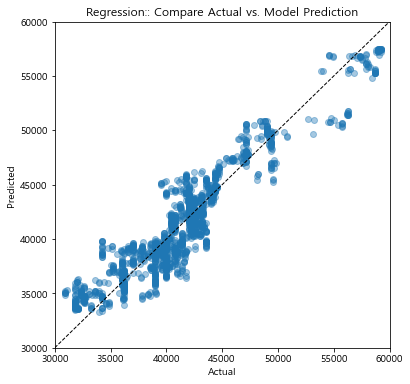

In [204]:
plt.figure(figsize=(6,6))
plt.scatter(test_y, fitted_full_model.predict(test_X_scaled), alpha=0.4)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Regression:: Compare Actual vs. Model Prediction")
plt.axline([30000,30000],[60000,60000], color='black', linewidth=1,linestyle='--',alpha=1)
plt.xlim([30000, 60000])
plt.ylim([30000, 60000])
plt.show()
# # x축은 실제 가격, y축은 예측가격이다. 만약 정답을 맞춘다면 정확히 선으로 일치되어 나올 거다.

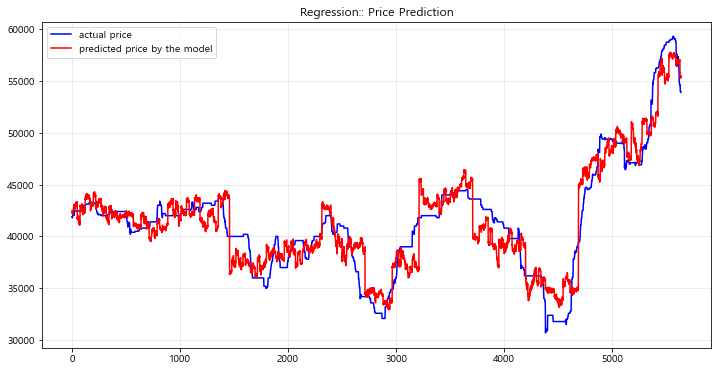

In [220]:
plt.figure(figsize=(12,6))
plt.title("Regression:: Price Prediction")
plt.plot(y,'b' ,label = 'actual price')
# plt.plot(y,'b',label = 'actual price',lw=8,alpha=0.15)
plt.plot(fitted_full_model.predict(pd.DataFrame(scaler.transform(X),columns=X.columns,index=X.index)),'r' ,label = 'predicted price by the model')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [24]:
OLS_residual2 = np.array(np.array(y) - np.array(fitted_full_model.predict(pd.DataFrame(scaler.transform(X),columns=X.columns,index=X.index))))

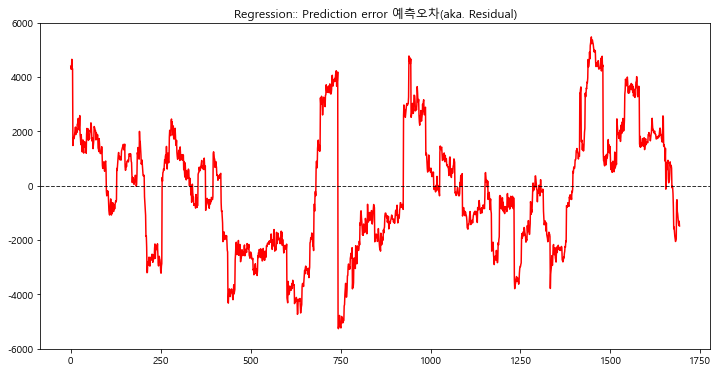

In [25]:
# 검증데이터에 대한 예측

# 예측데이터 잔차
plt.figure(figsize=(12,6))
plt.title("Regression:: Prediction error 예측오차(aka. Residual)")
plt.plot(OLS_residual2[3948:],'r')
plt.ylim([-6000, 6000])
plt.axhline(y=0, color='black', linewidth=1,linestyle='--',alpha=0.8)
# plt.grid(alpha=0.3)
plt.show()

### 2.3 랜덤포레스트
#### 2.3.1 RandomForestRegressor

In [18]:
# rf_model1
# RandomForestRegressor 무작위 분할
X = df2.iloc[:,1:]
y = df2.avg_price

In [20]:
def rfmodel(seed):
    train_x, test_x, train_y, test_y = train_test_split(X,y, train_size = 0.7, test_size = 0.3, random_state=seed)
    #학습
    scaler = MinMaxScaler()
    scaler.fit(train_x)
    train_X_scaled = pd.DataFrame(scaler.transform(train_x),columns=train_x.columns,index=train_x.index)
    test_X_scaled = pd.DataFrame(scaler.transform(test_x),columns=test_x.columns,index=test_x.index)

    rf_model1 = RandomForestRegressor(n_estimators = 200,max_depth=12)
    rf_model1.fit(train_X_scaled, train_y)

    y_pred = rf_model1.predict(test_X_scaled)
    return r2_score(np.array(test_y),np.array(y_pred.astype(int)))

test2 = []
for i in range(10):
    test2.append(rfmodel(i))
test2

[0.9979956503342118,
 0.9978098231150424,
 0.9979941096306769,
 0.9979722796702802,
 0.9975907629417546,
 0.9981565860117012,
 0.9984285949865582,
 0.9982498195104308,
 0.9980938308139637,
 0.997809918264121]

#### 2.3.2 시각화

Max Depth: 12
R2: 0.9979968414168353
RMSE: 243.65379367422867


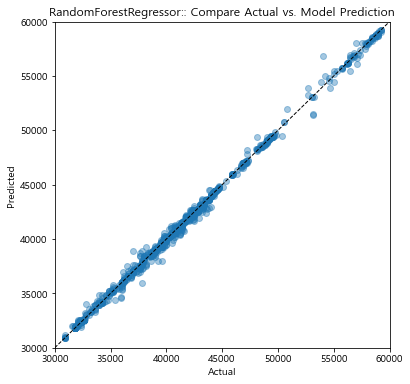

In [37]:
# rf_model1
# RandomForestRegressor 무작위 분할
X = df2.iloc[:,1:]
y = df2.avg_price

train_x, test_x, train_y, test_y = train_test_split(X,y, train_size = 0.7, test_size = 0.3)
#학습
scaler = MinMaxScaler()
scaler.fit(train_x)
train_X_scaled = pd.DataFrame(scaler.transform(train_x),columns=train_x.columns,index=train_x.index)
test_X_scaled = pd.DataFrame(scaler.transform(test_x),columns=test_x.columns,index=test_x.index)

rf_model1 = RandomForestRegressor(n_estimators = 200,max_depth=12)
rf_model1.fit(train_X_scaled, train_y)

y_pred = rf_model1.predict(test_X_scaled)

result = pd.DataFrame({'pred' : y_pred, 'real' : test_y})

test_X_scaled1 = test_X_scaled
test_y1 = test_y

print(f'Max Depth: {rf_model1.estimators_[0].tree_.max_depth}')
print(f'R2: {r2_score(np.array(test_y),np.array(y_pred.astype(int)))}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(test_y, y_pred))}')
plt.figure(figsize=(6,6))
plt.scatter(np.array(test_y), np.array(y_pred),alpha=0.4)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.axline([30000,30000],[60000,60000], color='black', linewidth=1,linestyle='--',alpha=1)
plt.xlim([30000, 60000])
plt.ylim([30000, 60000])
plt.title("RandomForestRegressor:: Compare Actual vs. Model Prediction")
plt.show()

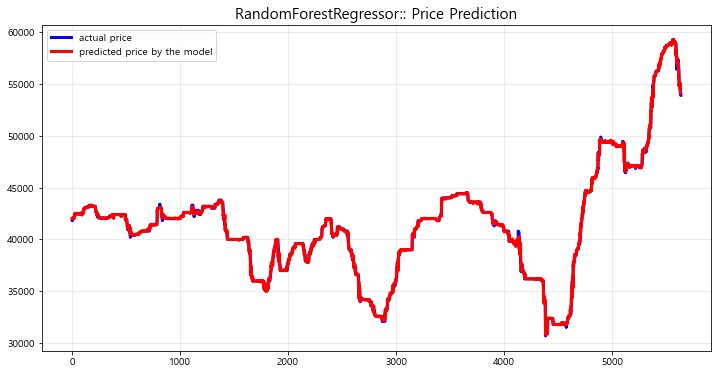

In [10]:
plt.figure(figsize=(12,6))
plt.title("RandomForestRegressor:: Price Prediction", fontsize=15)
plt.plot(y,'b',label = 'actual price',alpha=1,lw=3)
# plt.plot(y,'b',label = 'actual price',lw=8,alpha=0.1)
plt.plot(rf_model1.predict(pd.DataFrame(scaler.transform(X),columns=X.columns,index=X.index)),'r',label = 'predicted price by the model',lw=3)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

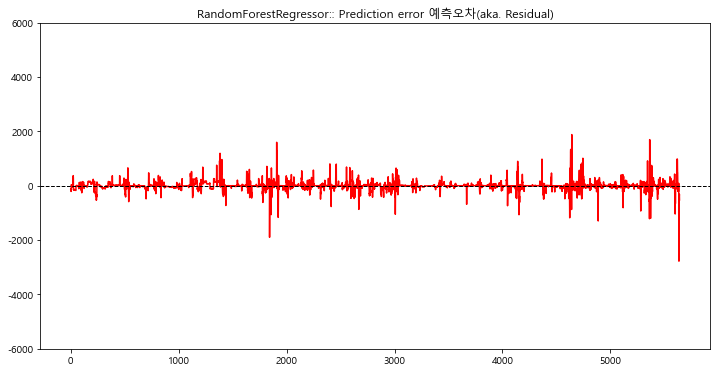

In [38]:
RFR_residual = np.array(np.array(y) - np.array(rf_model1.predict(pd.DataFrame(scaler.transform(X),columns=X.columns,index=X.index))))

plt.figure(figsize=(12,6))
plt.title("RandomForestRegressor:: Prediction error 예측오차(aka. Residual)")
plt.plot(RFR_residual,'r')
plt.ylim([-6000, 6000])
plt.axhline(y=0, color='black', linewidth=1,linestyle='--',alpha=1)
plt.show()

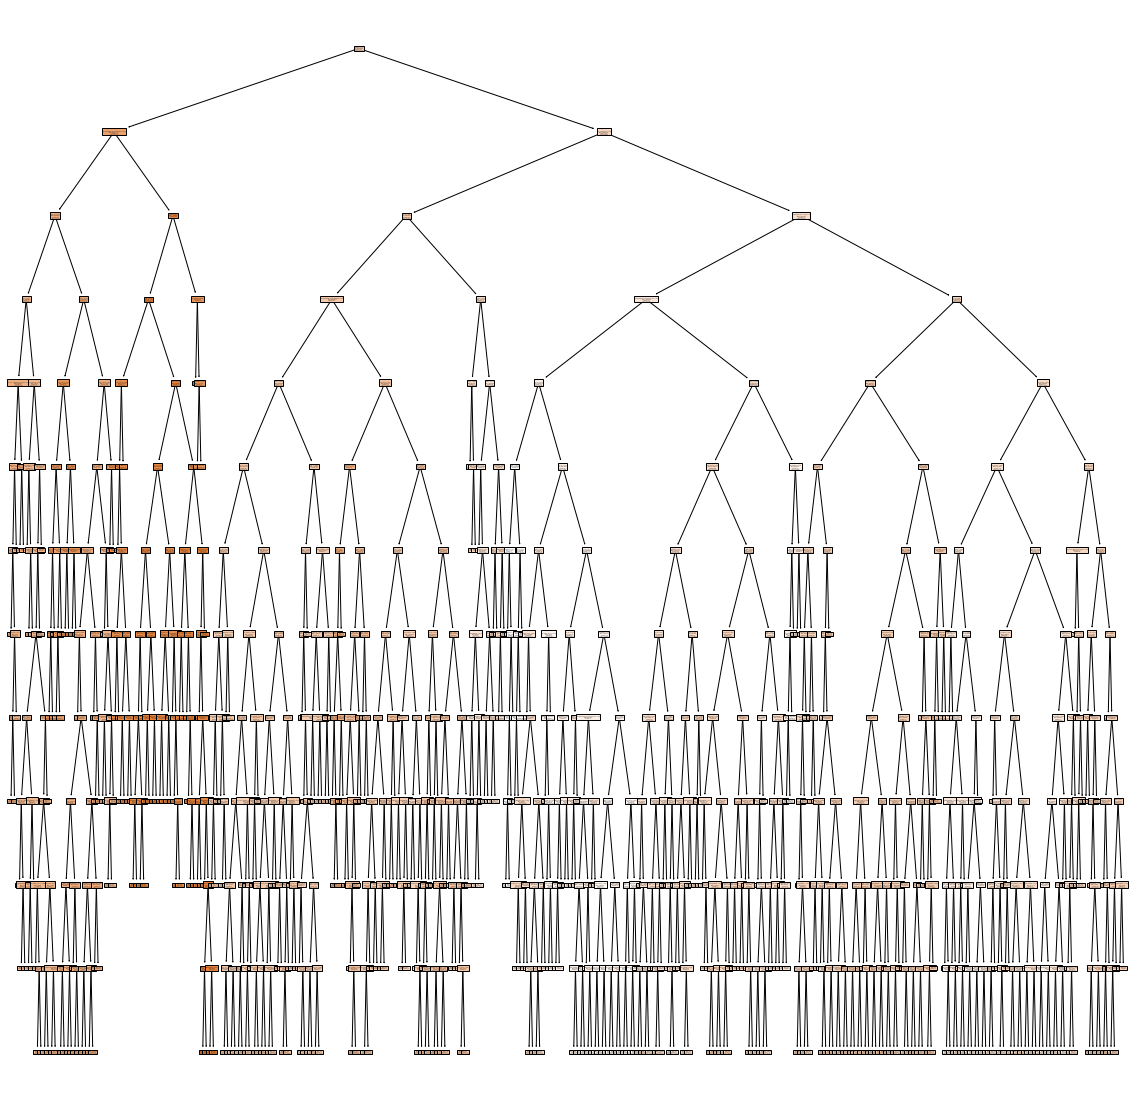

In [14]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(rf_model1.estimators_[0], feature_names=X.columns, filled=True)

#### 2.3.3 성능평가

In [247]:
# 모델에 의해 예측된/추정된 값
y_pred1 = rf_model1.predict(test_X_scaled1)
# y_pred2 = rf_model2.predict(test_X_scaled2)

perf_mat = pd.DataFrame(columns=["RF_Regressor"],index =['MSE', 'RMSE', 'MAE', 'R2'])

# 성능지표
perf_mat.loc['MSE']['RF_Regressor'] = metrics.mean_squared_error(test_y1,y_pred1)
# perf_mat.loc['MSE']['RF_Classifier'] = metrics.mean_squared_error(test_y2,y_pred2)

perf_mat.loc['RMSE']['RF_Regressor'] = np.sqrt(metrics.mean_squared_error(test_y1, y_pred1))
# perf_mat.loc['RMSE']['RF_Classifier'] = np.sqrt(metrics.mean_squared_error(test_y2, y_pred2))

perf_mat.loc['MAE']['RF_Regressor'] = metrics.mean_absolute_error(test_y1, y_pred1)
# perf_mat.loc['MAE']['RF_Classifier'] = metrics.mean_absolute_error(test_y2, y_pred2)

# perf_mat.loc['ACC']['RF_Regressor'] = metrics.accuracy_score(np.array(test_y1),np.array(y_pred1.astype(int)))
# perf_mat.loc['ACC']['RF_Classifier'] = metrics.accuracy_score(np.array(test_y2),np.array(y_pred2.astype(int)))

perf_mat.loc['R2']['RF_Regressor'] = r2_score(np.array(test_y1),np.array(y_pred1.astype(int)))
# perf_mat.loc['R2']['RF_Classifier'] = r2_score(np.array(test_y2),np.array(y_pred2.astype(int)))

perf_mat

,RF_Regressor
MSE,61109.041195
RMSE,247.20243
MAE,110.905475
R2,0.997868


#### 2.3.4 변수 중요도

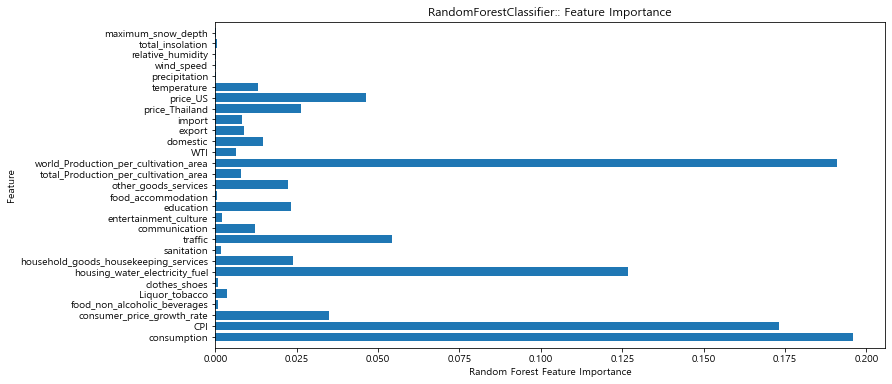

In [27]:
# Feature Importance
def plot_feature_importance(model):
    n_features = train_X_scaled.shape[1]
    plt.figure(figsize=(12,6))
    plt.barh(np.arange(n_features), model.feature_importances_, align="center")
    plt.yticks(np.arange(n_features), train_X_scaled.columns)
    plt.title("RandomForestClassifier:: Feature Importance")
    plt.xlabel("Random Forest Feature Importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    
plot_feature_importance(rf_model1)

In [28]:
perm = PermutationImportance(rf_model1,random_state=1).fit(test_X_scaled1,test_y1)
eli5.show_weights(perm, top = 29,feature_names = test_X_scaled1.columns.tolist())

Weight,Feature
0.2999 ± 0.0277,housing_water_electricity_fuel
0.1934 ± 0.0087,consumption
0.1807 ± 0.0065,world_Production_per_cultivation_area
0.1203 ± 0.0109,traffic
0.0771 ± 0.0060,CPI
0.0719 ± 0.0063,price_US
0.0499 ± 0.0042,household_goods_housekeeping_services
0.0445 ± 0.0042,price_Thailand
0.0305 ± 0.0026,other_goods_services
0.0205 ± 0.0026,domestic


<!-- #### 2.3.5 적용: 회귀분석 -->

### 2.3 벡터 자동 회귀 분석: VAR(Vector Auto Regression)
#### 2.3.1 정상성: Stationary time series

In [12]:
# AIC 기준을 사용하여 데이터의 stationarity를 찾기 위해 ADF(Advanced Dickey-Fuller test)와 같은 통계적 테스트를 수행
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

var_df=df3#pd.read_csv("data/rice_df2.csv")
var_df['date']=pd.to_datetime(var_df['date'])

var_df.set_index('date',inplace=True)

# var_df = var_df[['avg_price','consumption', 'CPI','world_Production_per_cultivation_area']]

var_list = list(var_df.columns)

<ipython-input-12-84322e100b01>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_df['date']=pd.to_datetime(var_df['date'])


In [13]:
var_df

,avg_price,consumption,CPI,consumer_price_growth_rate,housing_water_electricity_fuel,world_Production_per_cultivation_area,traffic,price_US,price_Thailand,temperature
date,,,,,,,,,,
2000-01-03,41900,93.600,66.6,2.3,3.7,2.626257,4.5,0.499000,247.500000,0.692857
2000-01-04,41900,93.600,66.6,2.3,3.7,2.626257,4.5,0.499000,247.500000,1.428571
2000-01-05,41800,93.600,66.6,2.3,3.7,2.626257,4.5,0.499000,247.500000,5.642857
2000-01-06,41800,93.600,66.6,2.3,3.7,2.626257,4.5,0.499000,247.500000,5.171429
2000-01-07,41900,93.600,66.6,2.3,3.7,2.626257,4.5,0.499000,247.500000,-3.750000
...,...,...,...,...,...,...,...,...,...,...
2021-11-05,54020,52.609,105.4,0.5,0.5,3.118175,-1.8,0.745517,496.120606,12.220000
2021-11-08,53880,52.609,105.4,0.5,0.5,3.118175,-1.8,0.745517,496.120606,9.786667
2021-11-09,53880,52.609,105.4,0.5,0.5,3.118175,-1.8,0.745517,496.120606,7.020000


In [14]:
stationary = list()
non_stationary = list()

for i in var_list:
    adfuller_test = adfuller(var_df[f'{i}'], autolag= "AIC")
    print(f"# {i}")
    print("ADF test statistic: {}".format(adfuller_test[0]))
    print("p-value: {}".format(adfuller_test[1]))
    if adfuller_test[1] < 0.05:
        stationary.append(f'{i}')
    elif adfuller_test[1] > 0.05:
        non_stationary.append(f'{i}')        
    print("====================================")

# avg_price
ADF test statistic: -1.0122937952380708
p-value: 0.7487540543218493
# consumption
ADF test statistic: -0.5944797324880658
p-value: 0.8722245086279843
# CPI
ADF test statistic: -1.2840683224126532
p-value: 0.6364291925878801
# consumer_price_growth_rate
ADF test statistic: -1.6787084040856628
p-value: 0.4421145810217301
# housing_water_electricity_fuel
ADF test statistic: -2.215437061452082
p-value: 0.20069047620327513
# world_Production_per_cultivation_area
ADF test statistic: 0.00747441304398735
p-value: 0.9591458670977372
# traffic
ADF test statistic: -2.683959425055037
p-value: 0.07685535708464575
# price_US
ADF test statistic: -1.668614380273141
p-value: 0.4473514901261649
# price_Thailand
ADF test statistic: -2.704065307581357
p-value: 0.07333743133111935
# temperature
ADF test statistic: -10.486400222076213
p-value: 1.177318954026645e-18


#### 2.3.1 차분: differencing

In [18]:
sta_df = var_df[stationary]

nonsta_df = var_df[non_stationary]
mydata_diff = nonsta_df.diff().dropna()

mydata_diff

stationary2 = list()
non_stationary2 = list()

for i in non_stationary:
    adfuller_test = adfuller(mydata_diff[f'{i}'], autolag= "AIC")
    print(f"{i}")
    print("ADF test statistic: {}".format(adfuller_test[0]))
    print("p-value: {}".format(adfuller_test[1]))
    if adfuller_test[1] < 0.05:
        stationary2.append(f'{i}')
    elif adfuller_test[1] > 0.05:
        non_stationary2.append(f'{i}')        
    print("====================================")

non_stationary2

var_df_diff = pd.merge(mydata_diff,sta_df,left_index=True, right_index=True,how='left')
var_df_diff # 모두 stationary 상태
var_df_diff.index = pd.DatetimeIndex(var_df_diff.index).to_period('D');var_df_diff

avg_price
ADF test statistic: -11.556754808492185
p-value: 3.34457428212917e-21
consumption
ADF test statistic: -75.28422572299185
p-value: 0.0
CPI
ADF test statistic: -75.29911534243007
p-value: 0.0
consumer_price_growth_rate
ADF test statistic: -75.0818428819782
p-value: 0.0
housing_water_electricity_fuel
ADF test statistic: -75.08208113800826
p-value: 0.0
world_Production_per_cultivation_area
ADF test statistic: -75.16372856699427
p-value: 0.0
traffic
ADF test statistic: -75.08119618421198
p-value: 0.0
price_US
ADF test statistic: -13.671209800172662
p-value: 1.4585328433675597e-25
price_Thailand
ADF test statistic: -10.61922118726383
p-value: 5.571249597479361e-19


,avg_price,consumption,CPI,consumer_price_growth_rate,housing_water_electricity_fuel,world_Production_per_cultivation_area,traffic,price_US,price_Thailand,temperature
date,,,,,,,,,,
2000-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.428571
2000-01-05,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.642857
2000-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.171429
2000-01-07,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.750000
2000-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.292857
...,...,...,...,...,...,...,...,...,...,...
2021-11-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.220000
2021-11-08,-140.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.786667
2021-11-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.020000


#### 2.3.3 모델링

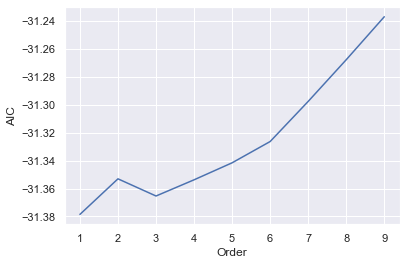

In [19]:
train = var_df_diff.iloc[:-200,:]
test = var_df_diff.iloc[-200:,:]
test

forecasting_model = VAR(train)
results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [20]:
results = forecasting_model.fit(1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 07, Dec, 2021
Time:                     15:49:56
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -31.2450
Nobs:                     5439.00    HQIC:                  -31.3319
Log likelihood:           8267.84    FPE:                2.35765e-14
AIC:                     -31.3785    Det(Omega_mle):     2.31049e-14
--------------------------------------------------------------------
Results for equation avg_price
                                              coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------------------
const                                            5.296173         2.543815            2.082           0.037
L1.avg_price                                     0.09998

In [24]:
laaged_values = train.values[-200:]

forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=200), index = test.index, columns= ['avg_price_d', 'consumption_d','CPI_d', 'consumer_price_growth_rate_d', 'housing_water_electricity_fuel_d', 'world_Production_per_cultivation_area_d', 'traffic_d', 'price_US_d', 'price_Thailand_d', 'temperature_d'])
forecast

,avg_price_d,consumption_d,CPI_d,consumer_price_growth_rate_d,housing_water_electricity_fuel_d,world_Production_per_cultivation_area_d,traffic_d,price_US_d,price_Thailand_d,temperature_d
date,,,,,,,,,,
2021-01-21,24.975781,-0.021196,0.019971,-0.001028,-0.001318,0.000257,-0.002905,0.000153,0.352815,1.755285
2021-01-22,7.453891,-0.021334,0.020102,-0.001034,-0.001331,0.000259,-0.002928,0.000028,0.284322,2.042114
2021-01-25,5.637550,-0.021053,0.019838,-0.001019,-0.001316,0.000255,-0.002893,0.000016,0.272662,2.323619
2021-01-26,5.394489,-0.020718,0.019523,-0.001002,-0.001298,0.000251,-0.002850,0.000016,0.266451,2.598188
2021-01-27,5.310380,-0.020385,0.019210,-0.000985,-0.001280,0.000247,-0.002807,0.000017,0.260916,2.865833
...,...,...,...,...,...,...,...,...,...,...
2021-11-05,2.759144,-0.007633,0.007224,-0.000336,-0.000594,0.000092,-0.001171,0.000054,0.051418,13.105962
2021-11-08,2.758656,-0.007630,0.007222,-0.000336,-0.000593,0.000092,-0.001170,0.000054,0.051378,13.107922
2021-11-09,2.758181,-0.007628,0.007220,-0.000336,-0.000593,0.000092,-0.001170,0.000054,0.051338,13.109831


In [28]:
forecast["avg_price_forecasted"] = var_df["avg_price"].iloc[-10-1] + forecast['avg_price_d'].cumsum()
forecast["consumption_forecasted"] = var_df["consumption"].iloc[-10-1] + forecast['consumption_d'].cumsum()
forecast["CPI_forecasted"] = var_df["CPI"].iloc[-10-1] + forecast['CPI_d'].cumsum()
forecast["world_Production_per_cultivation_area_forecasted"] = var_df["world_Production_per_cultivation_area"].iloc[-10-1] + forecast['world_Production_per_cultivation_area_d'].cumsum()
forecast
#왼쪽 4열(_d)은 차분에 대한 예측값, 오른쪽 4열(_forcasted)은 원래 시리즈에 대한 예측값

,avg_price_d,consumption_d,CPI_d,consumer_price_growth_rate_d,housing_water_electricity_fuel_d,world_Production_per_cultivation_area_d,traffic_d,price_US_d,price_Thailand_d,temperature_d,avg_price_forecasted,consumption_forecasted,CPI_forecasted,world_Production_per_cultivation_area_forecasted
date,,,,,,,,,,,,,,
2021-01-21,24.975781,-0.021196,0.019971,-0.001028,-0.001318,0.000257,-0.002905,0.000153,0.352815,1.755285,54644.975781,52.587804,105.419971,3.118432
2021-01-22,7.453891,-0.021334,0.020102,-0.001034,-0.001331,0.000259,-0.002928,0.000028,0.284322,2.042114,54652.429672,52.566470,105.440072,3.118691
2021-01-25,5.637550,-0.021053,0.019838,-0.001019,-0.001316,0.000255,-0.002893,0.000016,0.272662,2.323619,54658.067222,52.545416,105.459910,3.118946
2021-01-26,5.394489,-0.020718,0.019523,-0.001002,-0.001298,0.000251,-0.002850,0.000016,0.266451,2.598188,54663.461711,52.524698,105.479433,3.119197
2021-01-27,5.310380,-0.020385,0.019210,-0.000985,-0.001280,0.000247,-0.002807,0.000017,0.260916,2.865833,54668.772091,52.504313,105.498643,3.119445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-05,2.759144,-0.007633,0.007224,-0.000336,-0.000594,0.000092,-0.001171,0.000054,0.051418,13.105962,55290.357825,50.573293,107.323175,3.142715
2021-11-08,2.758656,-0.007630,0.007222,-0.000336,-0.000593,0.000092,-0.001170,0.000054,0.051378,13.107922,55293.116481,50.565663,107.330396,3.142807
2021-11-09,2.758181,-0.007628,0.007220,-0.000336,-0.000593,0.000092,-0.001170,0.000054,0.051338,13.109831,55295.874662,50.558035,107.337616,3.142898


<AxesSubplot:xlabel='date'>

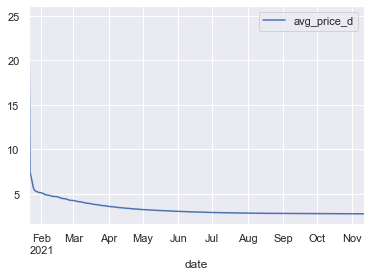

In [25]:
test =var_df.iloc[-200:,:];test
pd.set_option('mode.chained_assignment',  None)

forecast[['avg_price_d']].plot()
# test[['avg_price']].plot()

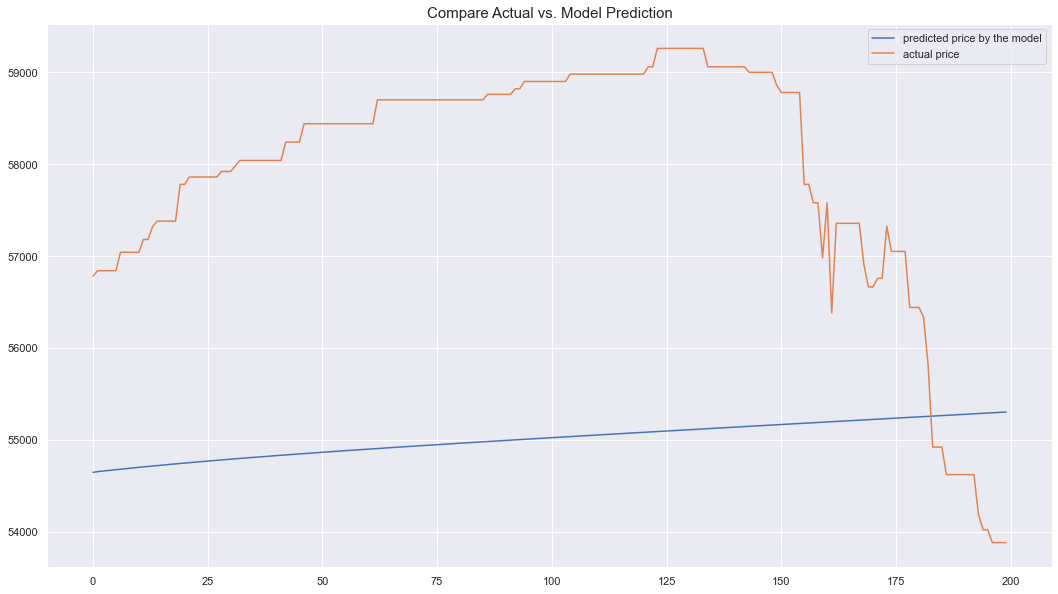

In [29]:
plt.figure(figsize=(18,10))
plt.title("Compare Actual vs. Model Prediction", fontsize=15)
plt.plot(np.array(forecast['avg_price_forecasted']), label = 'predicted price by the model')
plt.plot(np.array(test['avg_price']), label = 'actual price')
plt.legend()
plt.show()

### 2.4 LSTM

In [26]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
from matplotlib.pylab import rcParams 
# rcParams['figure.figsize']=20,10 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM,Dropout,Dense 
from sklearn.preprocessing import MinMaxScaler

In [27]:
# 테스트셋 비교
df=pd.read_csv("data/rice_df2.csv")
# df = df[selected_vars]

df["date"]=pd.to_datetime(df['date']) 
df.index=df['date']

data=df.sort_index(ascending=True,axis=0) 
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['date','avg_price']) 

for i in range(0,len(data)): 
    new_dataset["date"][i]=data['date'][i] 
    new_dataset["avg_price"][i]=data["avg_price"][i]

scaler=MinMaxScaler() 
new_dataset.index=new_dataset.date 
new_dataset.drop("date",axis=1,inplace=True) 
final_dataset=new_dataset.values 

train_data=final_dataset[0:3948,:]
valid_data=final_dataset[3948:,:] 
valid_data.shape

scaler=MinMaxScaler(feature_range=(0,1)) 
scaled_data=scaler.fit_transform(final_dataset) 

x_train_data,y_train_data=[],[] 
for i in range(60,len(train_data)): 
    x_train_data.append(scaled_data[i-60:i,0]) 
    y_train_data.append(scaled_data[i,0]) 
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data) 
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

lstm_model=Sequential() 
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1))) 
lstm_model.add(LSTM(units=50)) 
lstm_model.add(Dense(1)) 

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values 
inputs_data=inputs_data.reshape(-1,1) 
inputs_data=scaler.transform(inputs_data) 

lstm_model.compile(loss='mean_squared_error',optimizer='adam') 
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

X_test=[] 
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0]) 
X_test=np.array(X_test) 

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1)) 
predicted_closing_price=lstm_model.predict(X_test) 
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

lstm_model.save("saved_model.h5")

train_data=new_dataset[:3948] 
valid_data=new_dataset[3948:] 
valid_data['Predictions']=predicted_closing_price 

3888/3888 - 136s - loss: 2.9229e-04


<ipython-input-27-54f4bed43d96>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


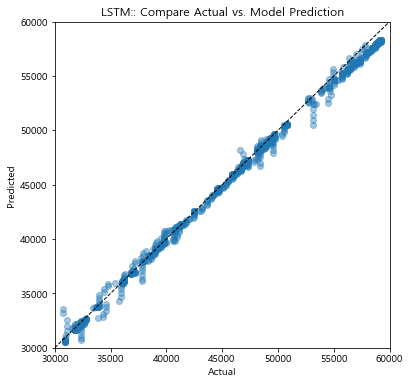

In [252]:
plt.figure(figsize=(6,6))
plt.scatter(valid_data['avg_price'], valid_data['Predictions'], alpha=0.4)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("LSTM:: Compare Actual vs. Model Prediction")
plt.axline([30000,30000],[60000,60000], color='black', linewidth=1,linestyle='--',alpha=1)
plt.xlim([30000, 60000])
plt.ylim([30000, 60000])
plt.show()
# x축은 실제 가격, y축은 예측가격이다. 만약 정답을 맞춘다면 정확히 선으로 일치되어 나올 거다.

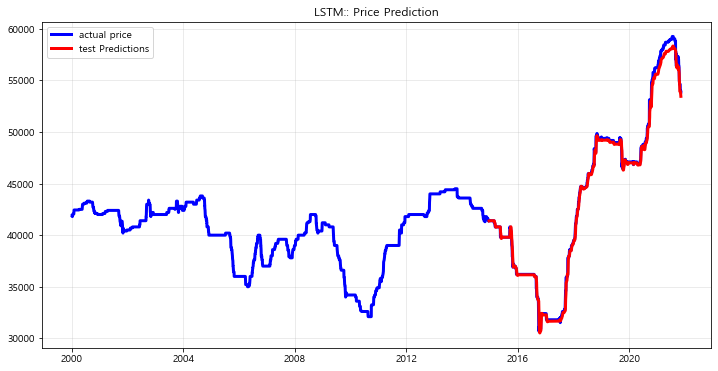

In [264]:
# 테스트셋만 비교
plt.figure(figsize=(12,6))
plt.title("LSTM:: Price Prediction")
plt.plot(train_data["avg_price"], 'b', label = 'actual price',lw=3) 
plt.plot(valid_data['avg_price'], 'b',lw=3)
plt.plot(valid_data['Predictions'],'r', label = 'test Predictions',lw=3)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [28]:
LSTM_Residual = np.array(valid_data['avg_price'] - valid_data['Predictions'])

No handles with labels found to put in legend.


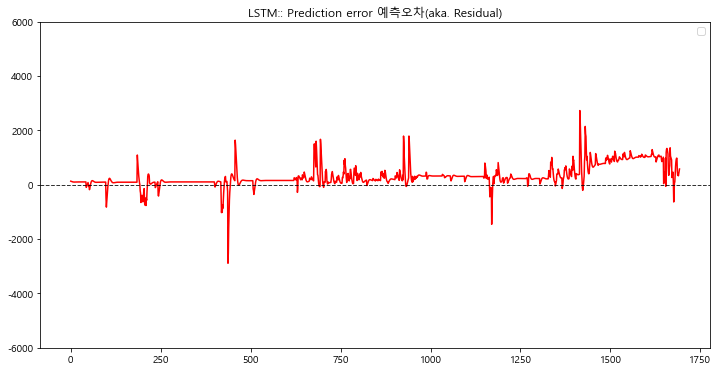

In [29]:
# 검증데이터에 대한 예측

# pred_y2 = fitted_full_model.predict(pd.DataFrame(scaler.transform(X),columns=X.columns,index=X.index))

# 예측데이터 잔차
plt.figure(figsize=(12,6))
plt.title("LSTM:: Prediction error 예측오차(aka. Residual)")
plt.plot(LSTM_Residual,'r')
plt.ylim([-6000, 6000])
plt.legend()
plt.axhline(y=0, color='black', linewidth=1,linestyle='--',alpha=0.8)
plt.show()

In [256]:
MAE = mean_absolute_error(valid_data['avg_price'], valid_data['Predictions'])
RMSE = np.sqrt(mean_squared_error(valid_data['avg_price'], valid_data['Predictions']))
# MSLE = mean_squared_log_error(test_label,pred_test)
# RMSLE = np.sqrt(mean_squared_log_error(test_label,pred_test))
R2 = r2_score(valid_data['avg_price'], valid_data['Predictions'])

pd.options.display.float_format = '{:.5f}'.format
Result = pd.DataFrame(data = [MAE,RMSE,R2],
                     index=['MAE','RMSE','R2'],
                     columns=['Results']);Result

,Results
MAE,266.67171
RMSE,430.40663
R2,0.99727


### 2.5 Regression vs. RandomForestRegressor vs. LSTM


|  | Regression | **RandomForestRegressor** | LSTM |  농촌경제연구원 |
|-------|-----|------|-----|-----|
| RMSE | 1884.973479 | **215.413278** | 296.15996 | 841.664897 |
| R2 | 0.875065 | **0.998984** | 0.99871| 0.9870561 |


In [39]:
rd={
    'OLS':list(OLS_residual2[3948:]),
    'RFR':list(RFR_residual[3948:]),
    'LSTM':list(LSTM_Residual)
}
residual = pd.DataFrame(rd,index=df.index[3948:])

In [ ]:
## # 예측데이터 잔차
plt.figure(figsize=(12,6))
plt.title("Prediction error")
plt.plot(residual.OLS,'C0',label = 'Regression', linewidth=1.5)#
plt.plot(residual.LSTM,'C1',label = 'LSTM', linewidth=1.5)
plt.plot(residual.RFR,'C2' ,label = 'RandomForest', linewidth=1.5)
plt.ylim([-6000, 6000])
plt.legend()
plt.axhline(y=0, color='black', linewidth=1,linestyle='--',alpha=1)
plt.show()

In [249]:
com = pd.read_csv('data/일반계가격.csv');com

,date,actual,pred
0,2017. 07,31891,31300
1,2017. 08,32556,31300
2,2017. 09,33168,31300
3,2018. 07,44126,44000
4,2018. 08,44435,44000
5,2018. 09,44618,44000
6,2019. 07,47446,46750
7,2019. 08,47157,46750
8,2019. 09,46834,46750
9,2020. 07,47846,47750


In [237]:
r2_score(com['actual'],com['pred'])

0.9870561181225767

In [238]:
np.sqrt(metrics.mean_squared_error(com['actual'], com['pred']))

841.6648976879101